# Binary Decision Tree Classifier

# Import tools
We are importing all the necessary libraries. 

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#scikit learn
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


from collections import Counter
import random
import time

## Constructing a model (algorithm)

In [104]:
class TreeNode:
    def __init__(self, X, y, split_index=None, threshold=None, left=None, right=None, info_gain=None, curr_depth=0, root=False, leaf=False,
                 classes=None, features = None):
        #DECISION NODE
        #index of the feature selected for splitting
        self.split_index = split_index
        #threshold value - certain value of the feature selected for the split
        self.threshold = threshold
        #left child
        self.left = left
        #right child
        self.right = right
        #information gain provided with the split (essentially this decide which split we will be making)
        self.info_gain = info_gain
        
        #LEAF NODE
        self.leaf = leaf
        
        #for BOTH NODES
        #depth of a node (this is only used for printing the tree)
        self.curr_depth = curr_depth
        #features in the current node
        self.X = X
        #classes in the current node
        self.y = y
        
        #string classes
        self.classes = classes
        
        
    def predict(self, X):
        "function for predicting classes"
        if self.split_index is None:
            return np.array([np.argmax(np.bincount(self.y)) for _ in range(X.shape[0])])
        pred = np.zeros(X.shape[0])
        left_idx = X[:, self.split_index] <= self.threshold
        pred[left_idx] = self.left.predict(X[left_idx])
        pred[~left_idx] = self.right.predict(X[~left_idx])
        return pred.astype(int)

    def print_split_idxs(self, node=None):
        "function for printing all split indices of the tree"
        if not node:
            node = self
        if node.split_index is not None:
            print(node.split_index, end=" ")
        if node.leaf == False:
            self.print_split_idxs(node.left)
            self.print_split_idxs(node.right)
    
    def print_split_idxs_and_thrshld(self, node=None):
        "function for printing all split indices of the tree"
        if not node:
            node = self
        if node.split_index is not None:
            print(f"X_{node.split_index}: {node.threshold}", end=" ")
        if node.leaf == False:
            self.print_split_idxs_and_thrshld(node.left)
            self.print_split_idxs_and_thrshld(node.right)

    def print_tree(self, tree=None, indent=" "):
        "function for visualizing the tree"
        
        if not tree:
            tree = self
            
        if tree.leaf:
            print(np.argmax(np.bincount(tree.y)), f"(#{len(tree.y)})")

        else:
            print(" X_\033[0m"+str(tree.split_index), "≤", np.round(tree.threshold,3), "?" ,np.round(tree.info_gain,3), f"(#{len(tree.y)})")
            print(tree.curr_depth + 1,":","%sleft: " % (indent), end="")
            self.print_tree(tree.left, indent + "   ")
            print(tree.curr_depth + 1 ,":","%sright: " % (indent), end="")
            self.print_tree(tree.right, indent + "   ") 
        

    
    def print_colorized_tree_with_original_labels(self, tree=None, indent=" ", features=None):
        "function for visualizing the tree"
        
        if not tree:
            tree = self
            
        if tree.leaf:
            class_counts = np.bincount(tree.y)
            max_class_count = np.max(class_counts)
            max_class_index = np.argmax(class_counts)
            num_classes = len(class_counts)

            # Define colors for different classes (you can customize these)
            colors = ["\033[95m", "\033[94m", "\033[93m", "\033[92m", "\033[91m"]

            # Assign a color based on the class with the highest count
            color_index = max_class_index % len(colors)
            class_color = colors[color_index]

            # Print the class label in the assigned color
            print(f"{class_color}{tree.classes[max_class_index]} ({max_class_count})\033[0m",f"{class_counts}")
            

        else:
            class_counts = np.bincount(tree.y)
            if features is not None:
                splitting_feature = features[tree.split_index]
                self.features = features
            else: 
                splitting_feature = str(tree.split_index)
                self.features = None
            print("\033[1mX_\033[0m"+f"\033[1m {splitting_feature}\033[0m", "\033[1m≤\033[0m", f"\033[1m{np.round(tree.threshold,3)}\033[0m", "?" ,np.round(tree.info_gain,3), f"(#{len(tree.y)})", f"{class_counts}")
            print(tree.curr_depth + 1,":","%sleft: " % (indent), end="")
            self.print_colorized_tree_with_original_labels(tree.left, indent + "   ", features = self.features)
            print(tree.curr_depth + 1 ,":","%sright: " % (indent), end="")
            self.print_colorized_tree_with_original_labels(tree.right, indent + "   ", features = self.features) 

def all_columns(X, rand):
    "this function returns the range of the features"
    return range(X.shape[1])


def to_int(y):
    "function to convert string classes to integer classes"
    y = y.copy()
    cl = np.unique(y)
    for i,cl in enumerate(cl):
        y[y==cl] = i
    return y.astype(int).flatten()


class Tree:
    def __init__(self, 
                 rand=None,
                 get_candidate_columns=all_columns,
                 min_samples=2, 
                 max_depth = float('inf')):
        
        if rand is None:
            rand = random.Random(42)
        self.rand = rand
        self.get_candidate_columns = get_candidate_columns #needed for random forests
        self.min_samples = min_samples
        self.max_depth = max_depth
        self.classes = None

    def to_int(self, y):
        "function to convert string classes to integer classes"
        y = y.copy()
        cl = np.unique(y)
        self.classes = cl
        for i,cl in enumerate(cl):
            y[y==cl] = i
        return y.astype(int).flatten()
    
    
    #MOST IMPORTANT FUNCTION - recursive function for building a binary tree using a recursive function. 
    #This function takes dataset as an input, performs a best split of the dataset - creating left and right child,
    #which either can be pure leaf node (node with only data points with one class) 
    #or a node with the remaining data and the condition that performs further splits of the data in that node.
    def build(self, X, y, curr_depth=0):
        '''recursive function to build the tree''' 
        
        #converting string classes to integer classes
        if curr_depth == 0:
            y = self.to_int(y)

        
        num_samples, num_features = np.shape(X)

        
        #store selected features we want to consider for finding the split
        candidates = np.array(self.get_candidate_columns(X, self.rand))
        self.rand.shuffle(candidates)

        
        #Now split until stopping conditions are met
        
        #if there's only one class present stop splitting and return leaf node
        if np.unique(y).shape[0] == 1:
            return TreeNode(X, y, curr_depth=curr_depth, leaf=True, classes = self.classes)
        #if the node doesn't have less than minimum number samples go for finding the best split
        if len(X) >= self.min_samples and curr_depth < self.max_depth:
            
            #on current data point apply best_split and obtain the split index, split threshold and information gain.
            split_index, split_threshold, split_info_gain = self.best_split(X, y, candidates)
            
            
            #now create the indices of the left and right child with the function split
            left_idxs, right_idxs = self.split(X[:, split_index], split_threshold)
        
            #if the information gain is positive create the left and right child and on each of the child recursively
            #call the build function. At the end return the current decision node.
        
            ##print("NEXT NODE left- recursion")
            # recur left
            left = self.build(X[left_idxs,:], y[left_idxs], curr_depth + 1)
            #recur right
            right = self.build(X[right_idxs,:], y[right_idxs], curr_depth + 1)


            if curr_depth == 0:

                #returning the root node
                return TreeNode(X, y, split_index, split_threshold, 
                                left, right, split_info_gain, curr_depth=0, root=True)
            
            #returing the decision node
            return TreeNode(X, y, split_index, split_threshold, left, right, split_info_gain, curr_depth=curr_depth)
        

        
        #returning the leaf node

        return TreeNode(X, y, curr_depth=curr_depth, leaf=True, classes = self.classes)

    def best_split(self, X, y, candidates):
        ''' function to find the best split '''
        #initialize the important variables
        split_index, split_threshold, split_info_gain = None, None, None
        max_info_gain = -float("inf")
        
        #loop through every feature
        for feature_index in candidates:
            #create a column of the current feature values of all data points
            X_column = X[:, feature_index]
            
            #find the unique values of that feature, one of the values might be chosen for the split
            possible_thresholds = np.unique(X_column)

            
            # loop over all the unique feature values present in the data
            # Iterate over adjacent unique sorted values to find midpoints
            thresholds = []
            for i in range(len(possible_thresholds) - 1):

                # Calculate midpoint between adjacent values
                threshold = (possible_thresholds[i] + possible_thresholds[i + 1]) / 2
                thresholds.append(threshold)
                
                
                
                #for this threshold value capture the information gain by calling the information_gain function.
                #This function will split the data points with respect to the threshold and calculate the infogain
                #of such split
                curr_info_gain = self.information_gain(y, X_column, threshold)
                #if the current info gain is larger than the last maximum info gain update the important variables.
                if curr_info_gain > max_info_gain: 
                    split_index = feature_index
                    split_threshold = threshold
                    split_info_gain = curr_info_gain
                    max_info_gain = curr_info_gain
            thresholds = []
                    
        #when two for loops are done return the best values of important variables.
        return split_index, split_threshold, split_info_gain
    
    def information_gain(self, y, X_column, split_threshold):
        "function to calculate the information gain of the split"

        #generate split, that is get the left and right indices 
        left_idxs, right_idxs = self.split(X_column, split_threshold)
        
        #if either left or right indices are zero, there is no information gain because we end up with
        #one empty node and the same node we perfomed a split on.
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0 
        
        #calculate the information gain of the split with gini index (Gini impurity)
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        weight_l = n_l / n
        weight_r = n_r / n
        gain = self.gini_index(y) - (weight_l*self.gini_index(y[left_idxs]) + weight_r*self.gini_index(y[right_idxs]))
        
        #return information gain
        return gain

    def split(self, X_column, split_threshold):
        "function to split the data"
        
        #left indices are the indices of data points which feature value is less than or equal to threshold
        left_idxs = np.argwhere(X_column <= split_threshold).flatten()
        
        #right indices are the indices of data points which feature value is larger than threshold
        right_idxs = np.argwhere(X_column > split_threshold).flatten()
        
        return left_idxs, right_idxs
        
    def gini_index(self, y):
        ''' function to compute gini index '''
        #gini_index = 1 - ∑p_i**2, where p_i = probability of class i 
        #Why would we use gini function? Unlike entropy function, gini doesn't have logarithmic part,
        #so by choosing gini function we have actually done a favor to us which is saving computation time - 
        #(it is easier to find square of a quantity than to find the logarithm.
        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
        return 1 - gini

## Test on the Iris Data
---
We will compare our solution with sklearn solution!

### 1. Our solution

#### Loading the data

In [105]:
iris_df = pd.read_csv("iris.csv", sep=",")
iris_df.head()

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


In [106]:
#adjustment to match the sklearn notation 
iris_df.columns = ['sepal length (cm)','sepal width (cm)', 'petal length (cm)', 'petal width (cm)'] + ["target"]
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


In [107]:
# Step 1: Separate features (X) and target variable (y)
X_iris_df = iris_df.drop(columns=['target'])  # Assuming the target column is named 'target'
y_iris_df = iris_df['target']  # Assuming the target column is named 'target'

# Step 2: Convert DataFrame to NumPy arrays
X_iris = X_iris_df.values
y_iris = y_iris_df.values

# Step 3: Perform the train-test split
Xiris_train, Xiris_test, yiris_train, yiris_test = train_test_split(X_iris, y_iris, test_size=0.2, random_state=42)

#### Fitting the model

In [108]:
import time
#creating the object of the DecisionClassifier class 
t = Tree(min_samples=2, rand=None, get_candidate_columns=all_columns)
a = time.time()
iris_tree = t.build(Xiris_train, yiris_train)
b = time.time()
print("Training time: ", b-a,"s")

Training time:  0.03219199180603027 s


#### Model visualization

In [109]:
iris_features=['sepal length (cm)','sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
iris_tree.print_colorized_tree_with_original_labels(features=iris_features)

X_ petal length (cm) ≤ 2.45 ? 0.333 (#120) [40 41 39]
1 :  left: Setosa (40) [40]
1 :  right: X_ petal length (cm) ≤ 4.75 ? 0.365 (#80) [ 0 41 39]
2 :     left: X_ petal width (cm) ≤ 1.65 ? 0.053 (#37) [ 0 36  1]
3 :        left: Versicolor (36) [ 0 36]
3 :        right: Virginica (1) [0 0 1]
2 :     right: X_ petal width (cm) ≤ 1.75 ? 0.067 (#43) [ 0  5 38]
3 :        left: X_ petal length (cm) ≤ 4.95 ? 0.167 (#8) [0 4 4]
4 :           left: Versicolor (2) [0 2]
4 :           right: X_ petal width (cm) ≤ 1.55 ? 0.222 (#6) [0 2 4]
5 :              left: Virginica (3) [0 0 3]
5 :              right: X_ petal length (cm) ≤ 5.45 ? 0.444 (#3) [0 2 1]
6 :                 left: Versicolor (2) [0 2]
6 :                 right: Virginica (1) [0 0 1]
3 :        right: X_ petal length (cm) ≤ 4.85 ? 0.017 (#35) [ 0  1 34]
4 :           left: X_ sepal length (cm) ≤ 5.95 ? 0.444 (#3) [0 1 2]
5 :              left: Versicolor (1) [0 1]
5 :              right: Virginica (2) [0 0 2]
4 :           right

#### Split features

In [110]:
iris_tree.print_split_idxs()

2 2 3 3 2 3 2 2 0 

In [111]:
iris_tree.print_split_idxs_and_thrshld()

X_2: 2.45 X_2: 4.75 X_3: 1.65 X_3: 1.75 X_2: 4.95 X_3: 1.55 X_2: 5.449999999999999 X_2: 4.85 X_0: 5.95 

#### Testing on the training data

In [112]:
yiris_train_pred = iris_tree.predict(Xiris_train)
yiris_train_pred

array([0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 2, 1, 1, 0, 0, 1, 2, 2, 1, 2, 1, 2,
       1, 0, 2, 1, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0, 1, 2, 0, 1, 2, 0, 2, 2,
       1, 1, 2, 1, 0, 1, 2, 0, 0, 1, 1, 0, 2, 0, 0, 1, 1, 2, 1, 2, 2, 1,
       0, 0, 2, 2, 0, 0, 0, 1, 2, 0, 2, 2, 0, 1, 1, 2, 1, 2, 0, 2, 1, 2,
       1, 1, 1, 0, 1, 1, 0, 1, 2, 2, 0, 1, 2, 2, 0, 2, 0, 1, 2, 2, 1, 2,
       1, 1, 2, 2, 0, 1, 2, 0, 1, 2])

In [48]:
accuracy_score(to_int(yiris_train), yiris_train_pred)

1.0

#### Making the prediction and model evaluation

In [49]:
yiris_test_pred = iris_tree.predict(Xiris_test)
yiris_test_pred

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2,
       0, 2, 2, 2, 2, 2, 0, 0])

#### Accuracy of the model

In [50]:
accuracy_score(to_int(yiris_test), yiris_test_pred)

1.0

#### Test if all instances are of one class

In [51]:
y_iris_uniques = np.array([np.tile([i], len(yiris_train)) for i in np.unique(yiris_train)])

for y_train in y_iris_uniques:
    #creating the object of the DecisionClassifier class 
    t = Tree(min_samples=2, rand=None, get_candidate_columns=all_columns)
    a = time.time()
    tree_ = t.build(Xiris_train, y_train)
    b = time.time()
    print("Training time: ", b-a,"s")
    tree_.print_colorized_tree_with_original_labels()

Training time:  0.00022339820861816406 s
Setosa (120) [120]
Training time:  0.00015974044799804688 s
Versicolor (120) [120]
Training time:  0.0004942417144775391 s
Virginica (120) [120]


### 2. Sklearn solution

In [52]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree

# Load the Iris dataset
iris_data = load_iris()

# Access the data and target variables
X_iris = iris_data.data  # Features
y_iris = iris_data.target  # Target variable (labels)

# Perform the train-test split
Xiris_train, Xiris_test, yiris_train, yiris_test = train_test_split(X_iris, y_iris, test_size=0.2, random_state=42)

In [53]:
from sklearn.tree import DecisionTreeClassifier

# Create a decision tree classifier
clf = DecisionTreeClassifier(random_state=42, max_depth=3)

# Fit the classifier to the training data
clf.fit(Xiris_train, yiris_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

#### Model visualization 



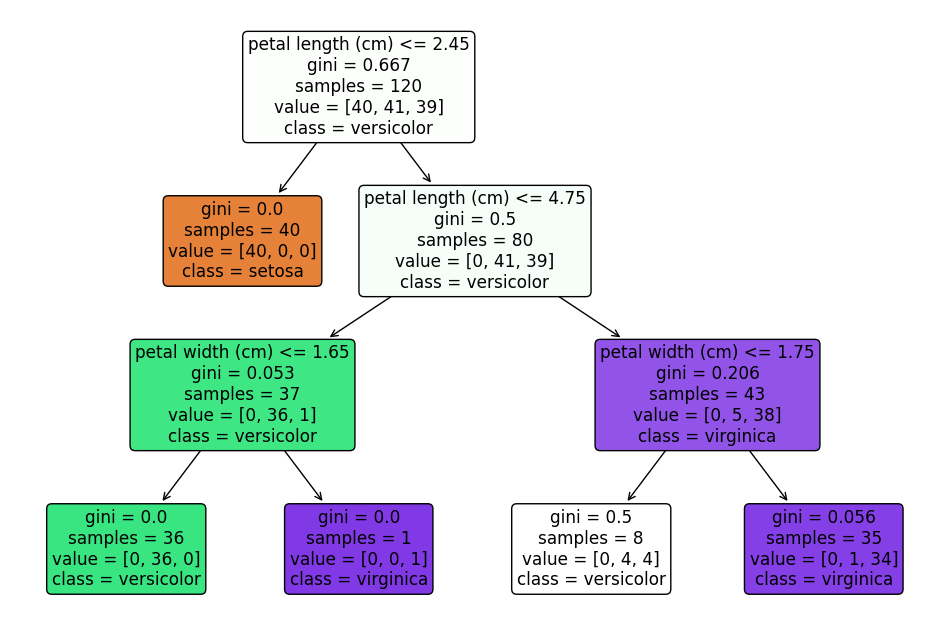

In [54]:
# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(clf, feature_names=iris_data.feature_names, class_names=iris_data.target_names, filled=True, rounded=True)
plt.show()

In [55]:
iris_tree.print_colorized_tree_with_original_labels(features=iris_features)

X_ petal length (cm) ≤ 2.45 ? 0.333 (#120) [40 41 39]
1 :  left: Setosa (40) [40]
1 :  right: X_ petal length (cm) ≤ 4.75 ? 0.365 (#80) [ 0 41 39]
2 :     left: X_ petal width (cm) ≤ 1.65 ? 0.053 (#37) [ 0 36  1]
3 :        left: Versicolor (36) [ 0 36]
3 :        right: Virginica (1) [0 0 1]
2 :     right: X_ petal width (cm) ≤ 1.75 ? 0.067 (#43) [ 0  5 38]
3 :        left: X_ petal length (cm) ≤ 4.95 ? 0.167 (#8) [0 4 4]
4 :           left: Versicolor (2) [0 2]
4 :           right: X_ petal width (cm) ≤ 1.55 ? 0.222 (#6) [0 2 4]
5 :              left: Virginica (3) [0 0 3]
5 :              right: X_ petal length (cm) ≤ 5.45 ? 0.444 (#3) [0 2 1]
6 :                 left: Versicolor (2) [0 2]
6 :                 right: Virginica (1) [0 0 1]
3 :        right: X_ petal length (cm) ≤ 4.85 ? 0.017 (#35) [ 0  1 34]
4 :           left: X_ sepal length (cm) ≤ 5.95 ? 0.444 (#3) [0 1 2]
5 :              left: Versicolor (1) [0 1]
5 :              right: Virginica (2) [0 0 2]
4 :           right

#### Feature Importances

In [56]:
features=['sepal length (cm)','sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
# After fitting the classifier to the training data
feature_importances = clf.feature_importances_

# Now, feature_importances contains the importance scores for each feature
# The higher the score, the more important the feature is for making splits in the tree

# You can also associate these scores with the feature names if you have them
# Assuming you have a list of feature names called feature_names
if features is not None:
    feature_importance_dict = dict(zip(features, feature_importances))
    # This will give you a dictionary where keys are feature names and values are importances
feature_importance_dict

{'sepal length (cm)': 0.0,
 'sepal width (cm)': 0.0,
 'petal length (cm)': 0.9346263239452668,
 'petal width (cm)': 0.06537367605473332}

## Cross validation
---

In [69]:
class CV_tree():
    def __init__(self, Tree, X, y, test_size, random_state, min_samples_range, max_depth_range, num_folds):
        self.Tree = Tree
        self.X = X
        self.y = to_int(y)
        self.test_size = test_size
        self.random_state = random_state
        self.min_samples_range = min_samples_range
        if len(self.min_samples_range) not in [2, 4, 9, 16]:
            raise ValueError("min_samples_range has to be of length 2, 4, 9, or 16")
        self.max_depth_range = max_depth_range
        self.num_folds = num_folds
        self.train_accuracies = [[] for _ in range(len(min_samples_range))]
        self.validation_accuracies = [[] for _ in range(len(min_samples_range))]
        self.best_min_samples = None
        self.best_max_depth = None
        self.best_accuracy = 0  # Initialize with a low value
    
    def perform_CV(self):
        # Perform the train-test split
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, 
                                                             test_size=self.test_size, random_state=self.random_state)
        
        skf = StratifiedKFold(n_splits=self.num_folds, shuffle=True, random_state=self.random_state)
        
        # Iterate over hyperparameter combinations and perform cross-validation
        for i,min_samples in enumerate(self.min_samples_range):
            for max_depth in self.max_depth_range:
                # Initialize variables to store the cross-validation results
                total_accuracy = 0
                total_train_acc = 0

                # Perform cross-validation
                for train_index, val_index in skf.split(X_train, y_train):
                    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
                    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

                    # Train a tree model with the current hyperparameters
                    t = self.Tree(min_samples=min_samples, max_depth=max_depth)
                    tree = t.build(X_train_fold, y_train_fold)

                    # Accuracy on trainig fold
                    y_train_pred = tree.predict(X_train_fold)
                    train_acc = np.mean(y_train_fold == y_train_pred)
                    total_train_acc += train_acc

                    # Evaluate the model on the validation fold
                    y_val_pred = tree.predict(X_val_fold)
                    accuracy = np.mean(y_val_pred == y_val_fold)
                    total_accuracy += accuracy

            
                avg_train_acc = total_train_acc / self.num_folds
                self.train_accuracies[i].append(avg_train_acc)

                # Calculate the average accuracy across folds
                avg_accuracy = total_accuracy / self.num_folds
                self.validation_accuracies[i].append(avg_accuracy)

                # Check if this hyperparameter combination is the best so far
                if avg_accuracy > self.best_accuracy:
                    self.best_accuracy = avg_accuracy
                    self.best_min_samples = min_samples
                    self.best_max_depth = max_depth
        return {"best_accuracy": self.best_accuracy,
                "best_min_samples": self.best_min_samples,
                "best_max_depth": self.best_max_depth}
        
    def plot_results(self):

        num_cols_rows = int(np.sqrt(len(self.min_samples_range)))

        # Define the number of min_samples values
        num_min_samples = len(self.min_samples_range)

        # Create a grid of subplots
        fig, axes = plt.subplots(num_cols_rows, num_cols_rows, figsize=(15, 10))
        fig.subplots_adjust(hspace=0.5)  # Adjust vertical spacing between subplots

        # Plot validation accuracies for each min_samples value
        for i in range(num_min_samples):
            min_samples_value = self.min_samples_range[i]
            validation_accuracy = self.validation_accuracies[i]
            train_accuracy = self.train_accuracies[i]

            row = i // num_cols_rows
            col = i % num_cols_rows

            ax = axes[row, col]
            ax.plot(self.max_depth_range, train_accuracy, label=f"Train Accuracy", c="k")
            ax.plot(self.max_depth_range, validation_accuracy, label=f"Validation Accuracy", c="r")
            #ax.set_xlabel('max_depth')
            #ax.set_ylabel('Accuracy')
            ax.set_title(f"min_samples={min_samples_value}")
            if i == np.argwhere(np.array(self.min_samples_range) == self.best_min_samples):
                ax.scatter(self.best_max_depth, self.best_accuracy, s=60, c="r", label="Best Validation Accuracy")
            ax.legend()


        # Add a common x-axis label
        fig.text(0.5, -0.02, 'max_depth', ha='center', va='center', size=15)
        fig.text(-0.02, 0.5, 'accuracy (%)', ha='center', va='center', size=15, rotation=90)

        # Show the plots
        plt.tight_layout()
        plt.show()

In [70]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

# Load the Iris dataset
iris_data = load_iris()

# Access the data and target variables
X_iris = iris_data.data  # Features
y_iris = iris_data.target  # Target variable (labels)

# Perform the train-test split
Xiris_train, Xiris_test, yiris_train, yiris_test = train_test_split(X_iris, y_iris, test_size=0.2, random_state=42)

In [71]:
cross_validation = CV_tree(Tree = Tree,
        X=X_iris, 
        y=y_iris, 
        test_size=0.2,
        random_state=42, 
        min_samples_range= np.arange(1,10),
        max_depth_range=[1,2,3,4,5,6],
        num_folds=5)

In [72]:
cross_validation.perform_CV()

{'best_accuracy': 0.9416666666666668,
 'best_min_samples': 5,
 'best_max_depth': 4}

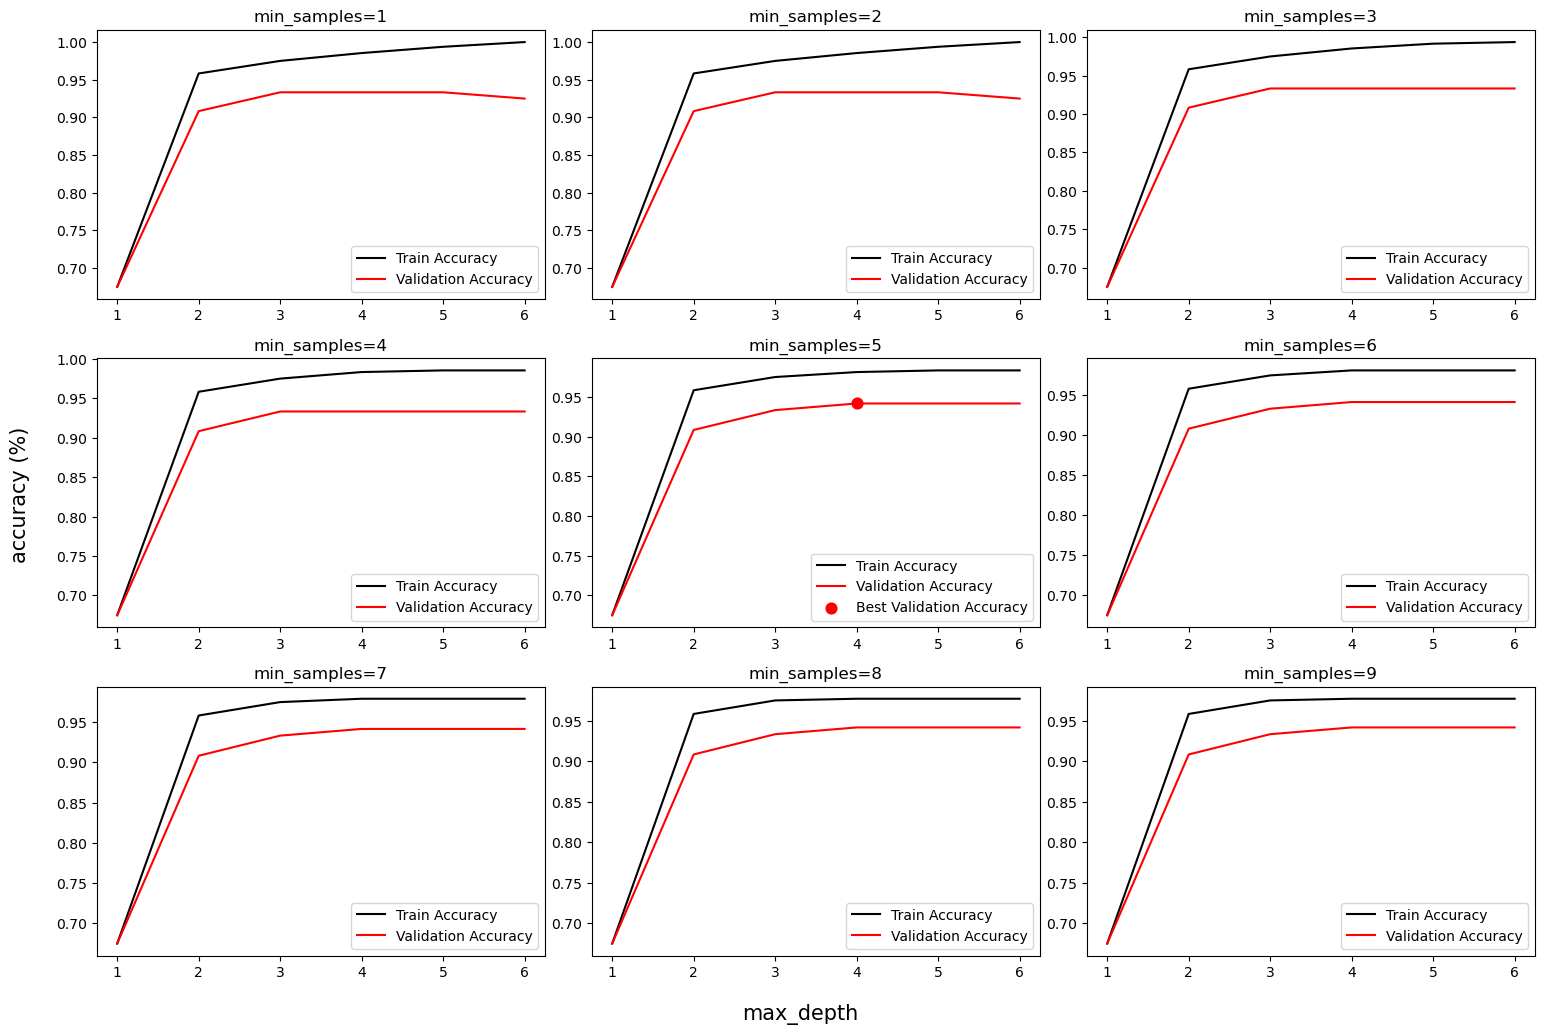

In [73]:
cross_validation.plot_results()

### Training on entire train set and validation on test set 

In [74]:
# Train a tree model with the current hyperparameters
t = Tree(min_samples=cross_validation.best_min_samples, max_depth=cross_validation.best_max_depth)
tree = t.build(Xiris_train, yiris_train)
yiris_test_pred = tree.predict(Xiris_test)
accuracy_score(yiris_test, yiris_test_pred)

1.0

---

---

## Synthetic data used in the seminar paper
---


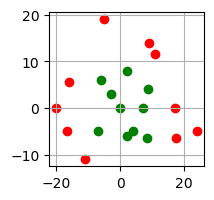

In [75]:
x0_red = np.array([-20, -16, 17, -16.5, -11, -5, 11, 9, 24, 17.5])
x1_red = np.array([0, 5.5, 0, -5, -11, 19, 11.5, 14, -5, -6.5])

x0_green = np.array([7, 0, -3, -6, -7, 2, 4, 2, 8.8, 8.3])
x1_green = np.array([0, 0, 3, 6, -5, 8, -5, -6, 4, -6.5])

plt.figure(figsize=(2,2))
plt.scatter(x0_red, x1_red, c="r")
plt.scatter(x0_green, x1_green, c="g")
plt.grid()

#### Prepare data for classification

In [76]:
x0 = np.concatenate((x0_red, x0_green))
x1 = np.concatenate((x1_red, x1_green))

target = np.concatenate((np.full(10,'red'), np.full(10,'green')))
data = np.stack((x0,x1), axis=1)

feature_names = ["X_0", "X_1"]
target_names = np.unique(target)

print(data)
print(target)
print(feature_names)
print(target_names)

[[-20.    0. ]
 [-16.    5.5]
 [ 17.    0. ]
 [-16.5  -5. ]
 [-11.  -11. ]
 [ -5.   19. ]
 [ 11.   11.5]
 [  9.   14. ]
 [ 24.   -5. ]
 [ 17.5  -6.5]
 [  7.    0. ]
 [  0.    0. ]
 [ -3.    3. ]
 [ -6.    6. ]
 [ -7.   -5. ]
 [  2.    8. ]
 [  4.   -5. ]
 [  2.   -6. ]
 [  8.8   4. ]
 [  8.3  -6.5]]
['red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'green'
 'green' 'green' 'green' 'green' 'green' 'green' 'green' 'green' 'green']
['X_0', 'X_1']
['green' 'red']


### 1. Our solution 

In [77]:
#creating the object of the DecisionClassifier class 
t = Tree(min_samples=2, rand=None, get_candidate_columns=all_columns)
a = time.time()
synthetic_tree = t.build(data, target)
b = time.time()
print("Training time: ", b-a,"s")

Training time:  0.014232158660888672 s


In [78]:
synthetic_tree.print_colorized_tree_with_original_labels()

X_ 0 ≤ 8.9 ? 0.167 (#20) [10 10]
1 :  left: X_ 0 ≤ -9.0 ? 0.323 (#15) [10  5]
2 :     left: red (4) [0 4]
2 :     right: X_ 1 ≤ 13.5 ? 0.165 (#11) [10  1]
3 :        left: green (10) [10]
3 :        right: red (1) [0 1]
1 :  right: red (5) [0 5]


In [79]:
synthetic_tree.print_split_idxs_and_thrshld()

X_0: 8.9 X_0: -9.0 X_1: 13.5 

In [80]:
dict_split_thr = {"X_0":[8.9, -9.], 
        "X_1":[13.5]}

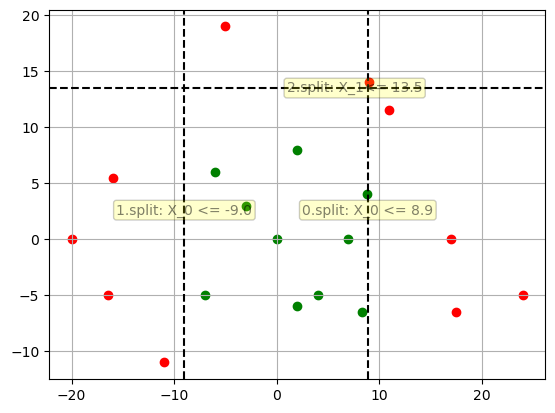

In [81]:
plt.scatter(x0_red, x1_red, c="r")
plt.scatter(x0_green, x1_green, c="g")
plt.grid()

i = 0 
for key, value in dict_split_thr.items():
    if key =="X_0":
        # Loop to add multiple vertical lines
        for val in value:
            plt.axvline(x=val, color='k', linestyle='--')
            # Add text in the middle of each vertical line
            plt.text(val, np.mean(x1_red), f'{i}.split: X_0 <= {val}', horizontalalignment='center',
                    bbox=dict(facecolor='yellow', edgecolor='black', boxstyle='round,pad=0.2', alpha=0.2), alpha=0.5)
            i += 1
    else:
        # Loop to add multiple vertical lines
        for val in value:
            plt.axhline(y=val, color='k', linestyle='--')
            plt.text(np.mean(x0_red),val, f'{i}.split: X_1<= {val}', verticalalignment='center',
                    bbox=dict(facecolor='yellow', edgecolor='black', boxstyle='round,pad=0.2',alpha=0.2), alpha=0.5)

In [82]:
synthetic_tree.print_colorized_tree_with_original_labels()

X_ 0 ≤ 8.9 ? 0.167 (#20) [10 10]
1 :  left: X_ 0 ≤ -9.0 ? 0.323 (#15) [10  5]
2 :     left: red (4) [0 4]
2 :     right: X_ 1 ≤ 13.5 ? 0.165 (#11) [10  1]
3 :        left: green (10) [10]
3 :        right: red (1) [0 1]
1 :  right: red (5) [0 5]


### 2. Sklearn solution

In [83]:
# Create a decision tree classifier
clf = DecisionTreeClassifier(random_state=42)

# Fit the classifier to the training data
clf.fit(data, target)

DecisionTreeClassifier(random_state=42)

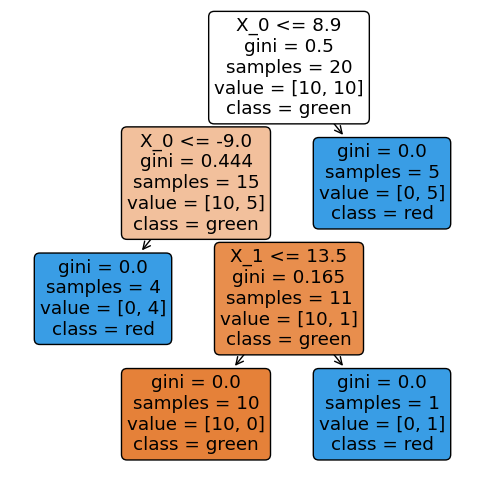

In [84]:
plt.figure(figsize=(6, 6))
plot_tree(clf, feature_names=feature_names, class_names=target_names, filled=True, rounded=True)
plt.show()

In [85]:
synthetic_tree.print_colorized_tree_with_original_labels()

X_ 0 ≤ 8.9 ? 0.167 (#20) [10 10]
1 :  left: X_ 0 ≤ -9.0 ? 0.323 (#15) [10  5]
2 :     left: red (4) [0 4]
2 :     right: X_ 1 ≤ 13.5 ? 0.165 (#11) [10  1]
3 :        left: green (10) [10]
3 :        right: red (1) [0 1]
1 :  right: red (5) [0 5]


## Vacation dataset

In [90]:
# Define the data as a list of lists
data = [
    [0, 10, 'Yes', 950, 75, 'Yes', 'Countryside'],
    [1, 10, 'Yes', 250, 78, 'Yes', 'Beach'],
    [2, 7, 'Yes', 600, 80, 'No', 'Beach'],
    [3, 8, 'Yes', 750, 67, 'Yes', 'Countryside'],
    [4, 10, 'Yes', 800, 73, 'Yes', 'Beach'],
    [5, 8, 'Yes', 850, 64, 'Yes', 'Countryside'],
    [6, 15, 'No', 350, 78, 'No', 'Beach'],
    [7, 8, 'Yes', 850, 81, 'Yes', 'Countryside'],
    [8, 6, 'No', 750, 59, 'Yes', 'Beach'],
    [9, 12, 'Yes', 1050, 54, 'Yes', 'Beach'],
    [10, 10, 'No', 230, 74, 'No', 'Countryside'],
    [11, 3, 'No', 630, 58, 'Yes', 'Countryside'],
    [12, 10, 'Yes', 830, 74, 'No', 'Beach'],
    [13, 12, 'No', 730, 52, 'Yes', 'Beach']
]

# Define the column names
columns = ['Record', 'Number of days', 'Family joining', 'Personal budget', 'Weather forecast', 'Explore new places', 'Target']

# Create a DataFrame
df = pd.DataFrame(data, columns=columns)
# Perform one-hot encoding for 'Family joining' and 'Explore new places' columns
df_encoded = pd.get_dummies(df, columns=['Family joining', 'Explore new places'],drop_first=True)

# Reorder the columns with the 'Target' column at the end
target_column = df_encoded.pop('Target')
df_encoded['Target'] = target_column

# Print the resulting DataFrame with the 'Target' column at the end
df_encoded

,Record,Number of days,Personal budget,Weather forecast,Family joining_Yes,Explore new places_Yes,Target
0,0,10,950,75,1,1,Countryside
1,1,10,250,78,1,1,Beach
2,2,7,600,80,1,0,Beach
3,3,8,750,67,1,1,Countryside
4,4,10,800,73,1,1,Beach
5,5,8,850,64,1,1,Countryside
6,6,15,350,78,0,0,Beach
7,7,8,850,81,1,1,Countryside
8,8,6,750,59,0,1,Beach
9,9,12,1050,54,1,1,Beach


In [93]:
vacation_features = df_encoded.columns[:-1]
vacation_features

X = df_encoded.iloc[:, :-1].values
Y = df_encoded.iloc[:, -1].values.reshape(-1,1)
X_train = X[:-3,1:]
X_test = X[-3:,1:]
y_train = Y[:-3]
y_test = Y[-3:]

#creating the object of the DecisionClassifier class 
t = Tree(min_samples=1, rand=None, get_candidate_columns=all_columns)
a = time.time()
vacation_tree = t.build(X_train, y_train)
b = time.time()
print("Training time: ", b-a,"s")

vacation_tree.print_colorized_tree_with_original_labels()

Training time:  0.006557941436767578 s
X_ 1 ≤ 825.0 ? 0.1 (#11) [6 5]
1 :  left: X_ 1 ≤ 240.0 ? 0.17 (#7) [5 2]
2 :     left: Countryside (1) [0 1]
2 :     right: X_ 2 ≤ 70.0 ? 0.111 (#6) [5 1]
3 :        left: X_ 3 ≤ 0.5 ? 0.5 (#2) [1 1]
4 :           left: Beach (1) [1]
4 :           right: Countryside (1) [0 1]
3 :        right: Beach (4) [4]
1 :  right: X_ 0 ≤ 11.0 ? 0.375 (#4) [1 3]
2 :     left: Countryside (3) [0 3]
2 :     right: Beach (1) [1]


In [94]:
vacation_tree.predict(X_test)

array([0, 1, 0])

## Data 1 
---

In [95]:
data1 = pd.read_csv("tki-resistance.csv", sep = ',', thousands = ',')
data1

,1000.0,1004.0,1008.0,1012.0,1016.0,1020.0,1024.0,1028.0,1032.0,1036.0,...,1756.0,1760.0,1764.0,1768.0,1772.0,1776.0,1780.0,1784.0,1788.0,Class
0,-0.000499,0.002677,0.001201,0.002078,0.001341,0.001567,-0.000023,0.001953,0.002255,0.001323,...,0.001971,0.001762,0.001282,0.000632,0.000083,0.000229,0.000210,0.000151,0.000224,Bcr-abl
1,0.001770,0.001721,0.001166,0.001840,0.001526,0.001266,0.001238,0.000895,0.000321,-0.000776,...,0.002380,0.002107,0.001263,0.000481,0.000072,0.000232,0.000142,0.000173,0.000072,Wild type
2,-0.000507,0.003220,0.001819,0.001667,0.001021,0.001617,-0.001703,0.002047,0.001158,0.000847,...,0.001769,0.001624,0.001141,0.000685,0.000279,0.000241,0.000093,0.000085,0.000415,Bcr-abl
3,0.000737,0.004078,0.001478,0.000385,0.001229,0.002770,0.001243,0.000943,-0.000005,0.000334,...,0.002107,0.001712,0.000998,0.000441,0.000094,0.000227,0.000280,0.000295,0.000099,Bcr-abl
4,-0.000138,0.001808,0.003028,0.004005,0.001344,0.001080,0.001843,0.003301,0.000221,-0.002049,...,0.002066,0.001958,0.001576,0.000527,-0.000114,0.000186,0.000370,0.000368,0.000094,Wild type
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,0.000628,0.001397,0.000865,0.002836,0.001973,0.001355,0.000515,0.001872,0.000121,-0.000279,...,0.001962,0.001766,0.001368,0.000662,0.000028,0.000141,0.000274,0.000308,0.000264,Bcr-abl
184,0.000010,0.001222,0.001867,0.002971,0.000934,0.000223,0.002711,0.003123,-0.000134,-0.001519,...,0.003090,0.003042,0.002188,0.000734,-0.000024,-0.000029,0.000585,0.000388,0.000228,Bcr-abl
185,0.000760,0.002908,0.001418,0.001388,0.000678,0.004257,0.001721,-0.000207,-0.001536,0.000575,...,0.001986,0.001829,0.001355,0.000590,-0.000018,0.000207,0.000193,0.000316,0.000331,Bcr-abl
186,-0.001140,0.002073,0.001825,0.001517,0.001867,0.001686,0.001279,0.002461,0.000664,-0.000507,...,0.002527,0.002258,0.001682,0.000808,0.000292,0.000227,0.000225,0.000109,0.000217,Wild type


Let's now implement our algorithm on this dataset. 

#### Train-Test split
Here I am creating train and test dataset. We will train our model on Train dataset and test it with Test dataset.

In [96]:
X = data1.iloc[:, :-1].values
Y = data1.iloc[:, -1].values.reshape(-1,1)
X_train = X[:130,:]
X_test = X[130:,:]
y_train = Y[:130]
y_test = Y[130:]

learn = X_train, y_train
test = X_test, y_test
features = data1.columns
targets = np.unique(Y)

In [97]:
y_train

array([['Bcr-abl'],
       ['Wild type'],
       ['Bcr-abl'],
       ['Bcr-abl'],
       ['Wild type'],
       ['Wild type'],
       ['Wild type'],
       ['Wild type'],
       ['Wild type'],
       ['Wild type'],
       ['Wild type'],
       ['Bcr-abl'],
       ['Wild type'],
       ['Bcr-abl'],
       ['Wild type'],
       ['Bcr-abl'],
       ['Wild type'],
       ['Wild type'],
       ['Bcr-abl'],
       ['Bcr-abl'],
       ['Bcr-abl'],
       ['Wild type'],
       ['Bcr-abl'],
       ['Bcr-abl'],
       ['Wild type'],
       ['Wild type'],
       ['Bcr-abl'],
       ['Bcr-abl'],
       ['Wild type'],
       ['Wild type'],
       ['Wild type'],
       ['Wild type'],
       ['Bcr-abl'],
       ['Bcr-abl'],
       ['Bcr-abl'],
       ['Bcr-abl'],
       ['Wild type'],
       ['Bcr-abl'],
       ['Wild type'],
       ['Wild type'],
       ['Bcr-abl'],
       ['Bcr-abl'],
       ['Wild type'],
       ['Bcr-abl'],
       ['Bcr-abl'],
       ['Bcr-abl'],
       ['Bcr-abl'],
       ['Bcr-a

In [98]:
y_train_int = to_int(y_train)

In [99]:
cross_validation = CV_tree(Tree = Tree,
        X=X_train, 
        y=y_train, 
        test_size=0.2,
        random_state=42, 
        min_samples_range = [2,4,6,10],
        max_depth_range=[2,5,10,15],
        num_folds=5)

In [100]:
cross_validation.perform_CV()

{'best_accuracy': 0.8452380952380952,
 'best_min_samples': 10,
 'best_max_depth': 5}

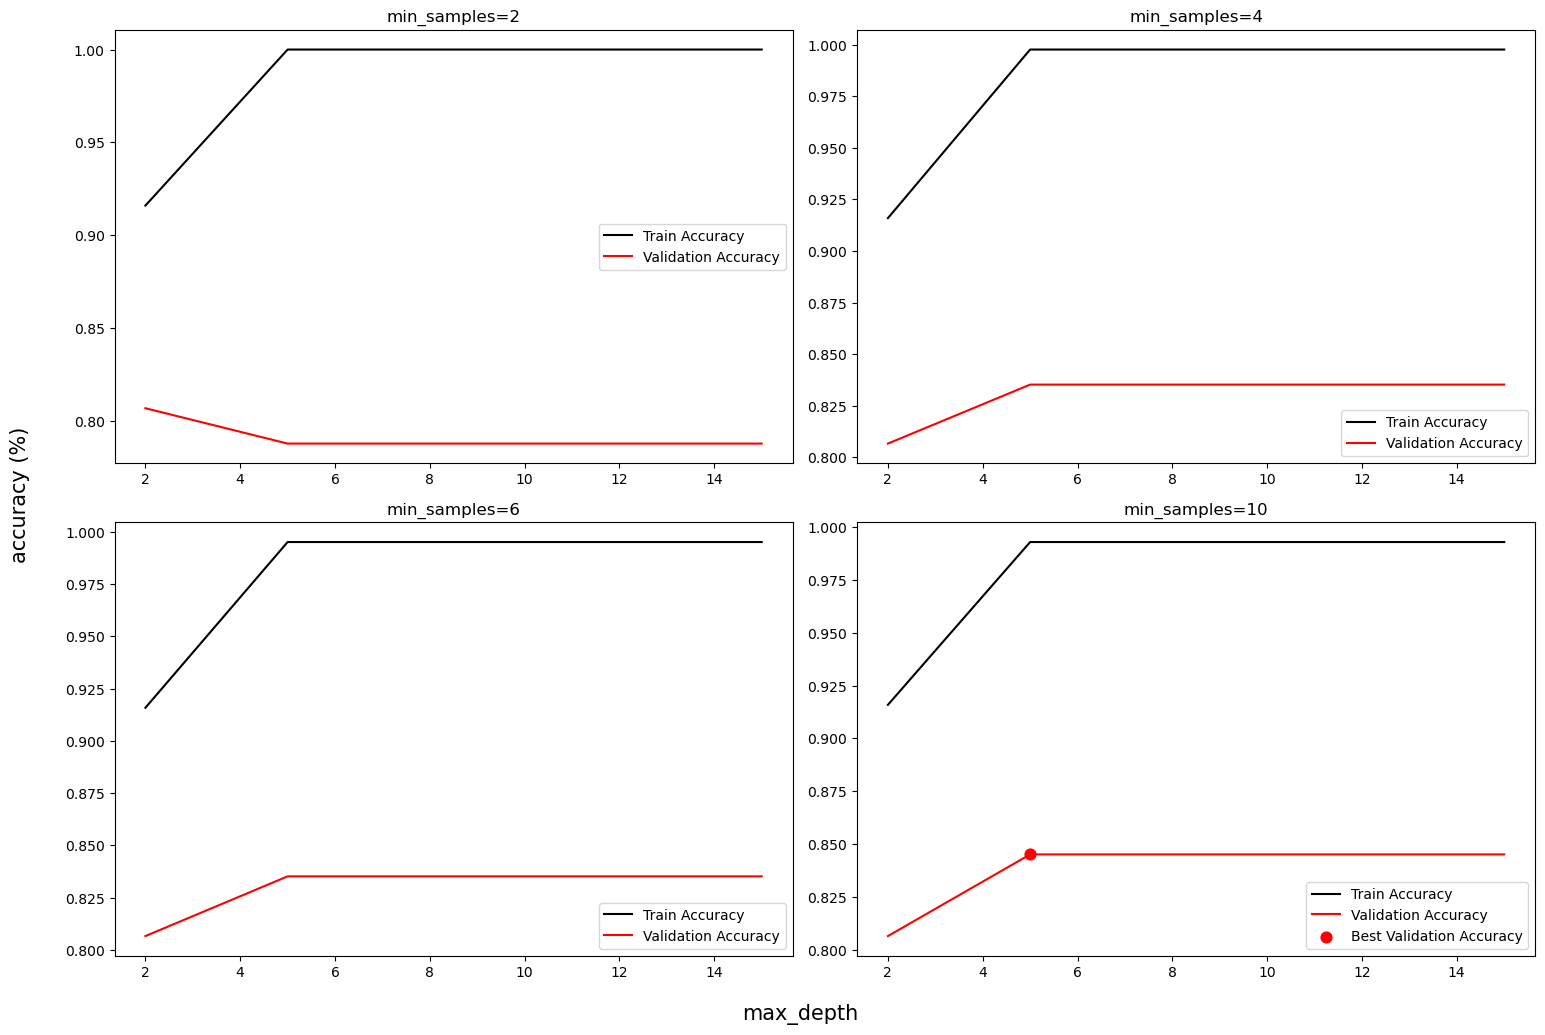

In [101]:
cross_validation.plot_results()

#### quick check that prediction method in the node works

#### Fitting (training) the model

In [202]:
import time
#creating the object of the DecisionClassifier class 
t = Tree(min_samples=2, rand=None, get_candidate_columns=all_columns)
a = time.time()
data1_tree = t.build(X_train, y_train)
b = time.time()
print("Training time: ", b-a,"s")

Training time:  2.5238430500030518 s


#### Model visualization 

We will use the method print.tree() to visualize our tree.

In [203]:
data1_tree.print_colorized_tree_with_original_labels(features=features)

X_ 1300.0 ≤ 0.001 ? 0.24 (#130) [67 63]
1 :  left: X_ 1148.0 ≤ 0.001 ? 0.133 (#71) [59 12]
2 :     left: X_ 1136.0 ≤ 0.003 ? 0.475 (#18) [ 7 11]
3 :        left: Bcr-abl (7) [7]
3 :        right: Wild type (11) [ 0 11]
2 :     right: X_ 1264.0 ≤ -0.0 ? 0.037 (#53) [52  1]
3 :        left: Wild type (1) [0 1]
3 :        right: Bcr-abl (52) [52]
1 :  right: X_ 1196.0 ≤ 0.003 ? 0.118 (#59) [ 8 51]
2 :     left: X_ 1312.0 ≤ -0.001 ? 0.075 (#51) [ 2 49]
3 :        left: Bcr-abl (2) [2]
3 :        right: Wild type (49) [ 0 49]
2 :     right: X_ 1440.0 ≤ -0.002 ? 0.375 (#8) [6 2]
3 :        left: Bcr-abl (6) [6]
3 :        right: Wild type (2) [0 2]


#### Split features

In [204]:
data1_tree.print_split_idxs()

75 37 34 66 49 78 110 

#### Testing on the training data

In [205]:
y_train_pred = data1_tree.predict(X_train)
y_train_pred

array([0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0])

In [206]:
y_train_int = to_int(y_train)
y_train_int

array([0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0])

In [207]:
accuracy_score(y_train_int, y_train_pred)

1.0

#### Making the prediction and model evaluation


We are using definded method predict() to determine the classes of the Test dataset - those will be stored in the Y_pred which we will then compare to Y_test with the help of sklearn library function called accuracy_score

In [208]:
y_pred_dtc = data1_tree.predict(X_test)
y_pred_dtc

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1])

#### Accuracy of the model

In [209]:
y_test_int = to_int(y_test)
y_test_int

array([0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0])

In [210]:
accuracy_score(y_test_int, y_pred_dtc)

0.8448275862068966

### 2. Sklearn solution

In [211]:
# Create a decision tree classifier
clf = DecisionTreeClassifier(random_state=42)

# Fit the classifier to the training data
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

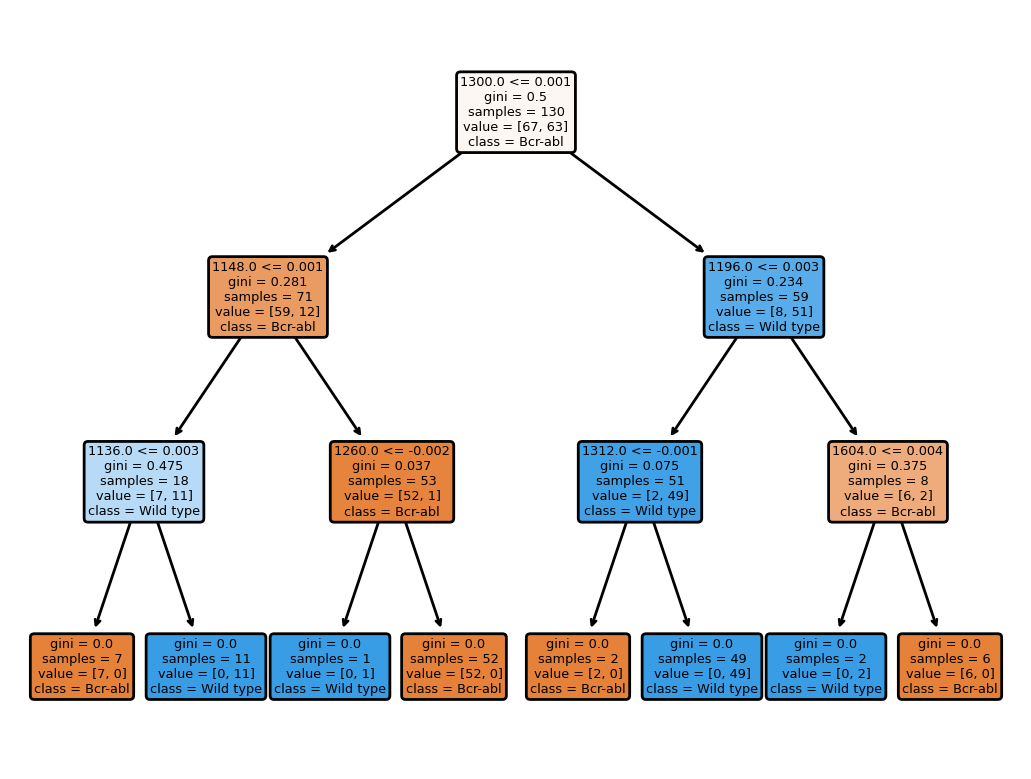

In [213]:
plt.figure(dpi=200)
plot_tree(clf, feature_names=features, class_names=targets, filled=True, rounded=True)
plt.show()

In [216]:
data1_tree.print_colorized_tree_with_original_labels(features=features)

X_ 1300.0 ≤ 0.001 ? 0.24 (#130) [67 63]
1 :  left: X_ 1148.0 ≤ 0.001 ? 0.133 (#71) [59 12]
2 :     left: X_ 1136.0 ≤ 0.003 ? 0.475 (#18) [ 7 11]
3 :        left: Bcr-abl (7) [7]
3 :        right: Wild type (11) [ 0 11]
2 :     right: X_ 1264.0 ≤ -0.0 ? 0.037 (#53) [52  1]
3 :        left: Wild type (1) [0 1]
3 :        right: Bcr-abl (52) [52]
1 :  right: X_ 1196.0 ≤ 0.003 ? 0.118 (#59) [ 8 51]
2 :     left: X_ 1312.0 ≤ -0.001 ? 0.075 (#51) [ 2 49]
3 :        left: Bcr-abl (2) [2]
3 :        right: Wild type (49) [ 0 49]
2 :     right: X_ 1440.0 ≤ -0.002 ? 0.375 (#8) [6 2]
3 :        left: Bcr-abl (6) [6]
3 :        right: Wild type (2) [0 2]


### Misclassification error

In [217]:
#Manual evaluation
s = 0
for i in range(len(y_pred_dtc)):
    if y_test_int[i] != y_pred_dtc[i]:
        s += 1
        
err = s/len(y_pred_dtc)
err

0.15517241379310345